In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv('../dataset/train.csv')

In [3]:
#train['Title']

In [4]:
train_data
del train_data['index']

In [5]:
train_data.head()

,Unnamed: 0,idx,Title,Score,ID,Image,Num_Comments,Created,Body,Label1Coronovirus,Label2Politics,Label3Non-Political,Label4Objects,Label5AskIndia
0,0,0,Coronavirus (COVID-19) Megathread - News and U...,287,fqqdsg,https://www.reddit.com/r/india/comments/fqqdsg...,6834,1.585451e+09,**Central thread for sharing coronavirus News ...,1,0,0,0,0
1,1,1,Firozabad police fact-checking zee news (trans...,680,fwcz7h,https://i.redd.it/jbal4gxocbr41.jpg,62,1.586258e+09,0,0,1,0,0,0
2,2,2,Donald Trump talks of ‘retaliation’ if India t...,371,fwclvi,https://economictimes.indiatimes.com/industry/...,135,1.586257e+09,0,1,0,0,0,0
3,3,3,Mom came up with this impressive idea to celeb...,3129,fvz69t,https://i.redd.it/gurfdfd1e7r41.jpg,183,1.586210e+09,0,0,0,1,0,0
4,4,4,9 PM 9 Minutes: House Catches Fire In Bihar; G...,181,fwdysc,https://news.abplive.com/news/india/coronaviru...,14,1.586262e+09,0,0,0,1,0,0


In [6]:
title_sents=[]
for i in range(train_data.shape[0]):
    title_sents.append(train_data.loc[i,'Title'])
    
        
#title_sents

# Framework and Packages used
I chose to use torchtext and spacy for the preprocessing of text as I am working on PyTorch and these packages provide most of the utilities needed.

## Torchtext
If it is not already installed uncomment line 1 For official documentation -https://torchtext.readthedocs.io/en/latest/

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
#pip install torchtext
import torchtext
import spacy

# Preprocessing Applied

## The Text has to preprocessed and broken into indiviual tokens from sentences before they can be embedded or sent to a model
### 1. Tokenisation
    -Done using spacy tokeniser. Better to use this rather than normal .split() method
    as it seperates punctuation attached to words like the what is (what?) and (what)
    would have been treated differently in .split method, but not with spacy
### 2. Lemmatisation
    -Also using Spacy, basically converts some word which are derived from otherwords to their root word. Like sleeping is converted to sleep.
### 3. Punctuation Removal
    -String class of python provides a list of all punctuations. Insteead of removing all punctuations, I decided to keep '?' as I think it does add some value in deciding the flair 


In [8]:
import string
k=string.punctuation
punct=[]
for i in range(len(k)):
    if(k[i]=='?'):
        continue
    else: 
        punct.append(k[i])
    


In [15]:
from nltk.corpus import stopwords
spacy_eng=spacy.load('en')
nlp=spacy.load("en_core_web_sm")
stop=set(stopwords.words('english'))
def tokenize_eng(text):
    sent=[]
    lema=nlp(text)
    for tok in spacy_eng.tokenizer(text):
        
        word=tok.lemma_
        #word=tok.text
        
        if word not in punct:
            if word not in stop:
                if(word!=word.split('_')[0]):
                    sent.extend(word.split('_'))
                else:
                    sent.append(word)
    
    return sent

In [16]:
sent=train_data.loc[2,'Title']
sent_=tokenize_eng(sent)
print(f"Tokenised {sent_}")
print(f"Original  {[sent]}")


Tokenised ['Donald', 'Trump', 'talk', '‘', 'retaliation', '’', 'India', 'turn', 'Covid', 'drug', 'request']
Original  ['Donald Trump talks of ‘retaliation’ if India turns down Covid drug request']


# Torchtext Fields
Torchtext can be used to load the data with certain preprocessing done while loading. The way this can be done is by declaring a Field. The Field specifies how you want a certain field to be processed.

I Have defined 3 fields for different types of data in my training set

### 1. TEXT-
For the textual data Title and body of the post

### 2. LABEL-
For the Output class Labels(Flairs)

In [17]:
from torchtext.data import Field


TEXT=Field(sequential=True,tokenize=tokenize_eng,lower=True,batch_first=True)
LABEL=Field(sequential=False,use_vocab=False,batch_first=True)
#NUM=Field(sequential=True,use_vocab=False,tokenize=toke,batch_first=True)

In [18]:

from torchtext.data import TabularDataset

flair_fields=[('Unnamed:0',None),
        ('Unnamed: 0.1',None),
        ('idx',None),
         ('Title',TEXT),
         ('Score',None),
         ('ID',None),
         ('Image',None),
         ('Num_Comments',None),
         ('Created',None),
         ('Body',None),
         ('Label1Coronovirus',LABEL),
         ('Label2Politics',LABEL),
         ('Label3Non-Political',LABEL),
         ('Label4Objects',LABEL),
         ('Label5AskIndia',LABEL)]
         

In [19]:
train_data_csv=TabularDataset(path='../dataset/train.csv',
                    format='csv',
                    skip_header=True,
                    fields=flair_fields)

In [21]:
"""Example of Datapoint """
print(f"Title- {train_data_csv[2].Title}")
print(f"Label for Coronavirus- {train_data_csv[2].Label1Coronovirus}")



Title- ['donald', 'trump', 'talk', '‘', 'retaliation', '’', 'india', 'turn', 'covid', 'drug', 'request']
Label for Coronavirus- 1


## Vocab Building
The TEXT Field requires a vocab using which it can numericalise the words Now either this vocab can be made using the given dataset or can be downloaded from a pretrained word embedding within the build_vocab feature of the Field

Here I have used Fasttext 300d Word Embedding and GloVe 200d.

In [23]:
TEXT.build_vocab(train_data_csv,min_freq=1,vectors='fasttext.simple.300d')

In [24]:
len(TEXT.vocab)

2160

## Converting to Batches
I decided to use Mini Batch gradient descent over Batch or SGD as Batch may take alot of time in RNN and SGD may be unstable

## Iterator Used
I used BucketIterator from torchtext which has the feature to club similar sized variable together so as to minimize padding required. Here this grouping I did using Context length as that varies largely between examples ranging from 0 to 14000.

In [25]:
from torchtext.data import Iterator,BucketIterator

train_iterator=BucketIterator(train_data_csv,
                             batch_size=32,
                             device=-1,
                             sort_key=lambda x:len(x.Title),
                             sort_within_batch=False,
                             repeat=False
                             )

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [26]:
train_data_csv[1].__dict__.keys()

dict_keys(['Title', 'Label1Coronovirus', 'Label2Politics', 'Label3Non-Political', 'Label4Objects', 'Label5AskIndia'])

In [27]:
#Each word's representation should be 300 dim
TEXT.vocab.vectors[100].shape

torch.Size([300])

In [28]:
TEXT.vocab.vectors[100].shape

torch.Size([300])

In [30]:
a=list(train_data_csv[0].__dict__.keys())
labels=a[1:]
labels

['Label1Coronovirus',
 'Label2Politics',
 'Label3Non-Political',
 'Label4Objects',
 'Label5AskIndia']

## Making a Wrapper Function for the batches¶
Currently the Iterator returns a function of torchtext.Batch type. Using this directly we'll need to define attributes in the train loop which will become messy and non resuable. Instead this wrapper function does that for each batch and returns a tuple of the type

(X[title], X[body], (X[num_comments], X[score]), y)

In [31]:

class BatchWrapper:
    def __init__(self,dat,x_var,*y_vars):
        self.dat=dat
        self.x_vars=x_var
        self.y_vars=y_vars
        
    def __iter__(self):
        for batch in self.dat:
            x=getattr(batch,self.x_vars)
            y=torch.cat([getattr(batch,y).unsqueeze(1) for y in self.y_vars[0]],dim=1).float()
            
            yield(x,y)

    def __len__(self):
        return len(self.dat)
        
train_dat=BatchWrapper(train_iterator,'Title',labels)

In [33]:
"""Example of the Wrapped Iterator"""
for x,y in enumerate(train_dat):
    print(x)
    print(y[1].shape)
    
    print(y[0].shape)
    
    break

0
torch.Size([32, 5])
torch.Size([32, 33])


In [34]:
"""Gives one training example"""
#next(train_dat.__iter__())

'Gives one training example'

## Pretrained vectors of Embedding
The weights of embedding will be copied to nn.Embedding layer. These weights are usually frozen during backprop, but I decided to not do that since many words like covid dont exist in vocab and currently have a 0 embbedding.

In [35]:
pretrained_vecs=TEXT.vocab.vectors

# Model

## Title Model
In this model I have used a BiLSTM for the Title. The reason I went for bidirectional LSTM is because it gets context from both sides of the word. This allows better representation of the word. 

In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self,n_vocab,
                 pretrained_vec,
                batch_size=16,
                embedding_dim=50,
                hidden_dim=64,
                num_layer=2,
                 dropout=0.3,
                 output_dims=5,
                bidirectional=True):
        super(Model,self).__init__()
        self.n_vocab=n_vocab
        self.batch_size=batch_size
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layer=num_layer
        self.bidirectional=bidirectional
        self.dropout=dropout
        
        self.output_dims=output_dims
        
        self.embedding=nn.Embedding(n_vocab,embedding_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad=False
        
        
        self.rnn=nn.LSTM(self.embedding_dim, self.hidden_dim,
                       num_layers=self.num_layer,
                       batch_first=True,bidirectional=self.bidirectional,
                        dropout=0.5)
        
        
        
        self.fc1=nn.Linear(hidden_dim*2,self.output_dims)
        
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,data):
           
        embedded=self.embedding(data)
        output,(hidden,_)=self.rnn(embedded)
        
        hidden=self.dropout(torch.cat((hidden[-1,:,:],hidden[-2,:,:]),dim=1))
        
        output=F.softmax(self.fc1(hidden))
        
        return output

In [37]:
ENC_EMB_DIM=300
HID_DIM=256
ENC_DROPOUT=0.5

Input_Vocab=len(TEXT.vocab)

model=Model(n_vocab=Input_Vocab,pretrained_vec=pretrained_vecs,embedding_dim=ENC_EMB_DIM,hidden_dim=HID_DIM,
           dropout=ENC_DROPOUT)

print(model)

Model(
  (embedding): Embedding(2160, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [59]:
import tqdm
import torch.optim as optim
optimizer=optim.Adam(model.parameters())

criterion=nn.CrossEntropyLoss()
EPOCH=2

## Training Loop
### Optimizer-
Adam- Combines advantages of Adaptive Gradient Algorithm and RMSProp

### Loss Function-
BCEWithLogitsLoss

In [60]:
epoch_loss_dat=[]
epoch_num_correct=[]

In [70]:
def train(model,train_iter):
    for epoch in range(1,20):
        running_loss=0.0
        running_corrects=0
        model.train()
        epoch_lo=0
        for x,y in tqdm.tqdm(train_iter):
            optimizer.zero_grad()
            #print(x)
            preds=model(x)
            
            #print(f"y: {y.shape}")
            preds=preds.squeeze(0)
        
            epoch_lo+=(torch.max(preds,1)[1]==torch.max(y,1)[1]).sum()
            
            loss=criterion(preds,torch.max(y,1)[1])
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()*x.size(0)
        epoch_loss=running_loss/train_data.shape[0]
        epoch_loss_dat.append(epoch_loss)
        print(f'Epoch :{epoch}, Training Loss: {epoch_loss}, Num_Correct={epoch_lo}')

In [71]:
train(model,train_dat)


  0%|          | 0/15 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

100%|██████████| 15/15 [00:07<00:00,  2.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :1, Training Loss: 1.622187690553403, Num_Correct=122



100%|██████████| 15/15 [00:06<00:00,  2.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :2, Training Loss: 1.5712441085004907, Num_Correct=141



100%|██████████| 15/15 [00:06<00:00,  2.34it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :3, Training Loss: 1.4937740818894691, Num_Correct=189



100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :4, Training Loss: 1.4502836768269287, Num_Correct=212



100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :5, Training Loss: 1.5188141368156256, Num_Correct=175



100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :6, Training Loss: 1.3909984953055674, Num_Correct=239



100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :7, Training Loss: 1.3543873768276191, Num_Correct=260



100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :8, Training Loss: 1.3523948454705657, Num_Correct=263



100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :9, Training Loss: 1.3254319716709613, Num_Correct=279



100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :10, Training Loss: 1.2847761568508995, Num_Correct=296



100%|██████████| 15/15 [00:06<00:00,  2.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :11, Training Loss: 1.2957679617984603, Num_Correct=290



100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :12, Training Loss: 1.2521451865391802, Num_Correct=307



100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :13, Training Loss: 1.2270938049663196, Num_Correct=323



100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :14, Training Loss: 1.2238501338071601, Num_Correct=320



100%|██████████| 15/15 [00:05<00:00,  2.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :15, Training Loss: 1.2033524704785983, Num_Correct=335



100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :16, Training Loss: 1.177586301184608, Num_Correct=346



100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :17, Training Loss: 1.1781905571955706, Num_Correct=343



100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch :18, Training Loss: 1.1542918644294173, Num_Correct=352



100%|██████████| 15/15 [00:08<00:00,  1.82it/s]

Epoch :19, Training Loss: 1.161202031008537, Num_Correct=353


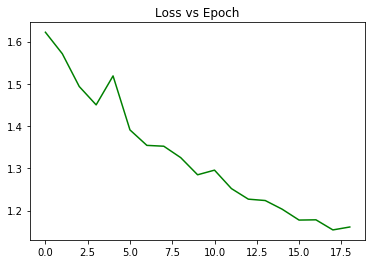

In [77]:
a=np.arange(19)
b=np.ones(19)*473
#figs,axs=plt.subplots(1,1,figsize=(10,5))

plt.title('Loss vs Epoch')
plt.plot(a,epoch_loss_dat,color='g')

#plt.title('Number of Correct vs Epoch')
#axs[1].plot(a,b,epoch_num_correct,color='teal')
#plt.show()

In [81]:
def evaluate(model,valid_iter,val_data_len):
    running_loss=0.0
    
    model.eval()
    
    epoch_lo=0
    for x,y in tqdm.tqdm(valid_iter):
        
        preds=model(x)
        preds=preds.squeeze(0)

        loss=criterion(preds,torch.max(y,1)[1])
        epoch_lo+=(torch.max(preds,1)[1]==torch.max(y,1)[1]).sum()
        #print(epoch_lo)
        running_loss+=loss.item()*x.shape[0]
    
    total_loss=running_loss/val_data_len
    print(f'Validation Loss: {total_loss}, Num_Correct={epoch_lo}')

In [50]:
from torchtext.data import TabularDataset

validation_flair_fields=[('Unnamed:0',None),('idx',None),('Title',TEXT),
         ('Score',None),('ID',None),('Image',None),('Num_Comments',None),('Created',None),('Body',None),
         ('Label1Coronovirus',LABEL),('Label2Politics',LABEL),('Label3Non-Political',LABEL),
         ('Label4Objects',LABEL),('Label5AskIndia',LABEL)]

In [51]:
val_data_csv=TabularDataset(path='../dataset/Val_data',
                    format='csv',
                    skip_header=True,
                    fields=validation_flair_fields)

In [55]:
from torchtext.data import Iterator,BucketIterator

val_iterator=BucketIterator(val_data_csv,
                             batch_size=32,
                             device=torch.device('cpu'),
                             sort_key=lambda x:len(x.Title),
                             sort_within_batch=True,
                             repeat=False
                             )

In [79]:
val_data=BatchWrapper(val_iterator,'Title',labels)

In [83]:
evaluate(model,val_data,len(val_data_csv))


  0%|          | 0/20 [00:00<?, ?it/s]/home/ishan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

100%|██████████| 20/20 [00:00<00:00, 21.33it/s]

Validation Loss: 1.5242602098045532, Num_Correct=225


In [ ]:
##Stop Words removing was good